# N-BaIoT Dataset Study 

Developped by Alexandre Le Mercier. *This code is under the MIT license as the rest of this package content (cf. the README.md file).*

Please note that importing classes from my package only needs to be done through "from vea import ...". This does not correspond to how libraries are imported in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import os
import sys
import tqdm as tq
from tqdm.notebook import tqdm
import warnings
import gc
import xgboost as xg
import lightgbm as lgb
import sklearn as sk
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import optuna

libraries = [pd, np, sns, tq, xg, lgb, sk, optuna]

warnings.filterwarnings("ignore")

# Print Python's version
print(f'Python version: {sys.version}\n')

# Print libraries versions
for lib in libraries:
    print(f'{lib.__name__}: {lib.__version__}')

# Set pandas options
pd.set_option('display.max_columns', 500)

# Print today's date
print("\nLast run: ", date.today())

Python version: 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]

pandas: 2.2.3
numpy: 2.1.3
seaborn: 0.13.2
tqdm: 4.67.0
xgboost: 2.1.2
lightgbm: 4.5.0
sklearn: 1.5.2
optuna: 4.0.0

Last run:  2024-12-12


In [2]:
big_df = pd.read_csv("../data/N-BaIoT/merged_dataset.csv")
#big_df.describe()

In [ ]:
# Remove values with infinite values in the row
# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.dropna()

In [3]:
#big_df = pd.read_csv("../data/N-BaIoT/merged_dataset.csv")
df = big_df[:1000000]
df.columns

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.01_covariance', 'HpHp_L0.01_pcc', 'label', 'File Name',
       ' Data Count', ' Feature Count', 'DeviceID', 'DeviceName',
       'Feature Name', 'Feature Description'],
      dtype='object', length=123)

In [4]:
# Remove features that are not rapidly retrievable (if we identify an attack when it happens, we can't use it to predict it)
for col in df.columns:
    if 'L5' not in col and col != 'label':
        df = df.drop(col, axis=1)

In [5]:
gc.collect()
df.shape

(1000000, 24)

In [7]:
df.label

0         benign
1         benign
2         benign
3         benign
4         benign
           ...  
999995     mirai
999996     mirai
999997     mirai
999998     mirai
999999     mirai
Name: label, Length: 1000000, dtype: object

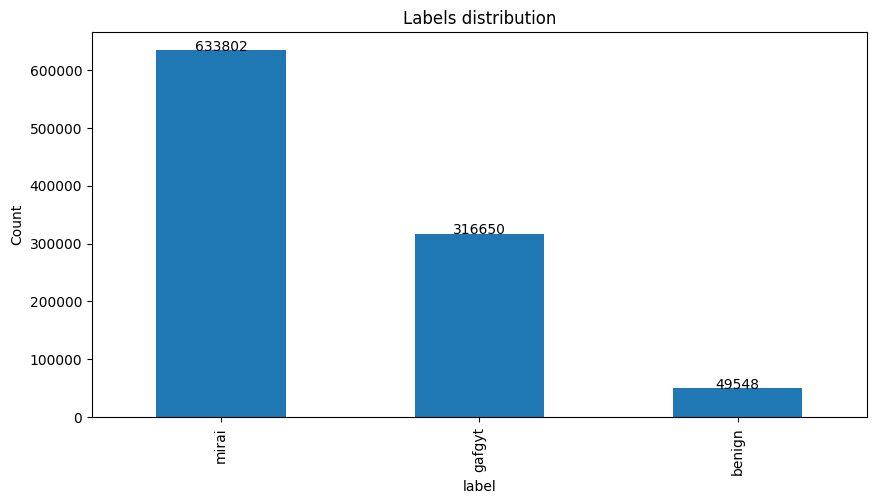

In [8]:
# Histogram of labels distribution using matplotlib, ordered in decreasing order and with each bar value indicated
plt.figure(figsize=(10, 5))
plt.title("Labels distribution")
plt.xlabel("Label")
plt.ylabel("Count")
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')
for i, v in enumerate(df['label'].value_counts().sort_values(ascending=False)):
    plt.text(i, v + 10, str(v), ha='center')

# 1. Feature Importance

## 1.1 Mirai

In [ ]:
"""# Only keep "label == BenignTraffic" and "label == "DDoS-ICMP_Fragmentation" rows
df_mirai = df[df['label'].isin(['benign', 'mirai'])]

# Replace "BenignTraffic" with 0 and "DDoS-ICMP_Fragmentation" with 1
df_mirai['label'] = df_mirai['label'].replace({'benign': 0, 'mirai': 1})

df_mirai.shape"""

(683350, 24)

In [ ]:
# Train/test split
"""X_train, X_test, y_train, y_test = train_test_split(df_mirai.drop(columns=['label']), df_mirai['label'], test_size=0.2, random_state=42)"""

In [ ]:
"""# Train and evaluate accuracy and F1 score of a kNN model
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}")"""

Accuracy: 0.99990
F1 score: 0.99990


In [19]:
"""# Print feature importance in descending order
feature_importance = model.feature_importances_
features = X_train.columns
indices = np.argsort(feature_importance)[::-1]
for i in indices:
    if feature_importance[i] > 0.001:
        print(f"{features[i]}: {feature_importance[i]:.5f}")"""

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [ ]:
"""# Compute mutual information between each feature and the target for the first 1000 rows
mi = mutual_info_classif(X_train.iloc[:500000], y_train.iloc[:500000])  # Ensure proper slicing for DataFrames
mi = pd.Series(mi, index=X_train.columns)  # Create a Series with feature names as the index
mi = mi.sort_values(ascending=False)  # Sort mutual information in descending order

# Display the mutual information values
mi"""

HpHp_L5_magnitude     0.292436
HH_L5_magnitude       0.285024
MI_dir_L5_weight      0.259694
H_L5_weight           0.259694
HH_jit_L5_mean        0.257857
HH_L5_mean            0.257612
MI_dir_L5_mean        0.228817
H_L5_mean             0.228714
HpHp_L5_mean          0.227574
MI_dir_L5_variance    0.121734
H_L5_variance         0.121375
HH_L5_weight          0.077117
HH_jit_L5_weight      0.076681
HH_L5_std             0.053011
HH_L5_radius          0.038005
HpHp_L5_weight        0.016331
HH_L5_pcc             0.014633
HpHp_L5_std           0.009637
HH_L5_covariance      0.001687
HpHp_L5_radius        0.000487
HH_jit_L5_variance    0.000331
HpHp_L5_covariance    0.000231
HpHp_L5_pcc           0.000000
dtype: float64

Text(0.5, 1.0, "Kde plot of 'MI_dir_L5_weight' feature")

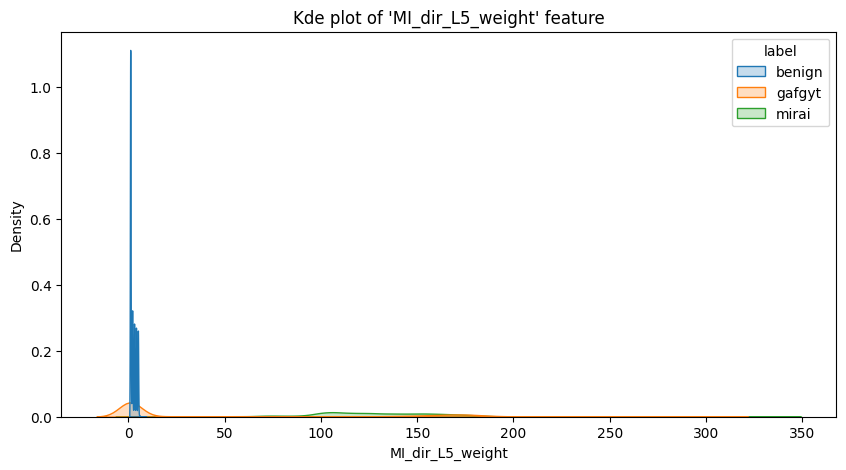

In [ ]:
"""# Kde plot of "ICMP" in df which hue is "label"
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='MI_dir_L5_weight', hue='label', fill=True, common_norm=False)
plt.title("Kde plot of 'MI_dir_L5_weight' feature")"""

In [ ]:
"""# Free some space
del df_mirai
gc.collect()"""

6251

## 1.2 gafgyt

In [ ]:
"""# Only keep "label == BenignTraffic" and "label == "DDoS-SlorLoris" rows
df_sl = df[df['label'].isin(['benign', 'gafgyt'])]

# Replace "BenignTraffic" with 0 and "DDoS-ICMP_Fragmentation" with 1
df_sl['label'] = df_sl['label'].replace({'benign': 0, 'gafgyt': 1})

df_sl.shape"""

(366198, 24)

In [ ]:
# Train/test split
"""X_train, X_test, y_train, y_test = train_test_split(df_sl.drop(columns=['label']), df_sl['label'], test_size=0.2, random_state=42)"""

In [ ]:
"""# Train and evaluate accuracy and F1 score of a XGBoost model
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")"""

Accuracy: 0.99947
F1 score: 0.99947



In [ ]:
"""# Free some space
del df_sl
gc.collect()"""

7

## 1.6 All at the same time

In [23]:
df_encoded = df.copy()

df_encoded['label'] = df['label'].replace({'benign': 0,
                                            'mirai': 1,
                                            'gafgyt': 1})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['label']), df_encoded['label'], test_size=0.2, random_state=42)

# Train and evaluate accuracy and F1 score of a XGBoost model
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.99977
F1 score: 0.99978



# 2. SLARC evaluation

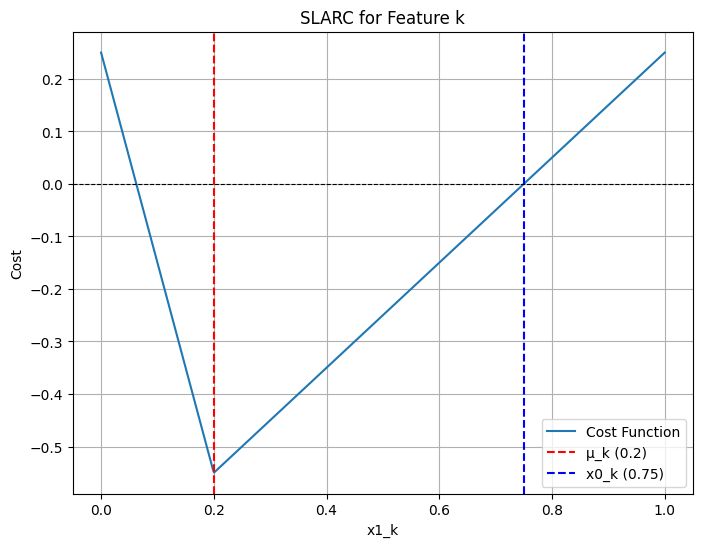

In [24]:
# Define parameters
mu = 0.2
x0 = 0.75
x_values = np.linspace(0, 1, 500)

val_at_mu = x0 - mu
val_at_1 = 1 - x0

def cost_function_continuous(x, mu, x0):
    if x >= mu:
        return x - x0
    else:
        slope = -4
        return slope * x + val_at_1

# Recompute the function values
y_values_continuous = [cost_function_continuous(x, mu, x0) for x in x_values]

# Plot the continuous function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values_continuous, label="Cost Function")
plt.axvline(mu, color="red", linestyle="--", label="µ_k (0.2)")
plt.axvline(x0, color="blue", linestyle="--", label="x0_k (0.75)")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("SLARC for Feature k")
plt.xlabel("x1_k")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Assume df is your preprocessed DataFrame
# Filter data for 'DDoS-ICMP_Fragmentation' and 'BenignTraffic'
attack_type = 'gafgyt'
df_attack = df[df['label'].isin(['benign', attack_type])].copy()

# Encode labels: 0 for 'BenignTraffic', 1 for the attack type
df_attack['label'] = df_attack['label'].replace({'benign': 0, attack_type: 1})

# Separate features and labels
X = df_attack.drop(columns=['label'])
y = df_attack['label']

# Provided feature importances for 'DDoS-ICMP_Fragmentation'
omega_k_dict = {
    'HpHp_L5_magnitude':     0.292436,
    'HH_L5_magnitude':       0.285024,
    'MI_dir_L5_weight':      0.259694,
    'H_L5_weight':           0.259694,
    'HH_jit_L5_mean':        0.257857,
    'HH_L5_mean':            0.257612,
    'MI_dir_L5_mean':        0.228817,
    'H_L5_mean':             0.228714,
    'HpHp_L5_mean':          0.227574,
    'MI_dir_L5_variance':    0.121734,
    'H_L5_variance':         0.121375,
    'HH_L5_weight':          0.077117,
    'HH_jit_L5_weight':      0.076681,
    'HH_L5_std':             0.053011,
    'HH_L5_radius':          0.038005,
    'HpHp_L5_weight':        0.016331,
    'HH_L5_pcc':             0.014633,
    'HpHp_L5_std':           0.009637,
    'HH_L5_covariance':      0.001687,
    'HpHp_L5_radius':        0.000487,
    'HH_jit_L5_variance':    0.000331,
    'HpHp_L5_covariance':    0.000231,
    'HpHp_L5_pcc':           0.000000
}

# Set omega_k to 0 for unspecified features
all_features = X.columns.tolist()
omega_k = {feature: omega_k_dict.get(feature, 0) for feature in all_features}

# Convert omega_k to a pandas Series for alignment
omega_k_series = pd.Series(omega_k)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Compute μ_k and σ_k from the training data
mu_k = X_train.mean()
sigma_k = X_train.std()

# Replace any zero standard deviations to avoid division by zero
sigma_k = sigma_k.replace(0, 1e-6)

# Compute x_k_min and x_k_max (1st and 99th percentiles)
x_k_min = X_train.quantile(0.01)
x_k_max = X_train.quantile(0.99)

# Vectorized computation of SLARC
def compute_SLARC_vectorized(X, mu_k, sigma_k, x_k_min, x_k_max, omega_k_series):
    # Compute rho_k_x for all samples and features
    numerator_x = x_k_max - X
    denominator_x = X - x_k_min
    # Avoid division by zero
    denominator_x = denominator_x.replace(0, 1e-6)
    rho_k_x = numerator_x / denominator_x

    # Compute rho_k_mu (Series aligned by columns)
    numerator_mu = x_k_max - mu_k
    denominator_mu = mu_k - x_k_min
    denominator_mu = denominator_mu.replace(0, 1e-6)
    rho_k_mu = numerator_mu / denominator_mu

    # Compute epsilon_k
    condition = (rho_k_mu - 1) * (rho_k_x - 1)
    epsilon_k = pd.DataFrame(
        np.where(condition >= 0, 1, np.maximum(rho_k_mu, 1 / rho_k_mu)),
        index=X.index,
        columns=X.columns
    )

    delta_x = np.abs(X - mu_k)

    # Compute SLARC_k(x)
    numerator = (omega_k_series / sigma_k) * epsilon_k
    slarc_k = numerator * delta_x

    return slarc_k

"""# Compute SLARC for training and testing data
X_train_slarc = compute_SLARC_vectorized(
    X_train, mu_k, sigma_k, x_k_min, x_k_max, omega_k_series
)
X_test_slarc = compute_SLARC_vectorized(
    X_test, mu_k, sigma_k, x_k_min, x_k_max, omega_k_series
)

# Now, train the XGBoost model on the SLARC-transformed features
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_slarc, y_train)

# Make predictions
y_pred = model.predict(X_test_slarc)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Attack Type: {attack_type}")
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 Score: {f1:.5f}")"""

'# Compute SLARC for training and testing data\nX_train_slarc = compute_SLARC_vectorized(\n    X_train, mu_k, sigma_k, x_k_min, x_k_max, omega_k_series\n)\nX_test_slarc = compute_SLARC_vectorized(\n    X_test, mu_k, sigma_k, x_k_min, x_k_max, omega_k_series\n)\n\n# Now, train the XGBoost model on the SLARC-transformed features\nmodel = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric=\'logloss\')\nmodel.fit(X_train_slarc, y_train)\n\n# Make predictions\ny_pred = model.predict(X_test_slarc)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nf1 = f1_score(y_test, y_pred, average=\'weighted\')\n\nprint(f"Attack Type: {attack_type}")\nprint(f"Accuracy: {accuracy:.5f}")\nprint(f"F1 Score: {f1:.5f}")'

# 3. Evasion attacks

In [34]:
%autoreload 2

import sys

# Add the parent directory of the 'Tests' folder to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from attacks.header import *
from attacks.HillClimbing import HillClimbing
from attacks.SimulatedAnnealing import SimulatedAnnealing
from attacks.TabuSearch import TabuSearch
from neighborhoods.Radar import Radar

#----------------------------------------------
attack_id = 2
omega_k_dict = {
    'HpHp_L5_magnitude':     0.292436,
    'HH_L5_magnitude':       0.285024,
    'MI_dir_L5_weight':      0.259694,
    'H_L5_weight':           0.259694,
    'HH_jit_L5_mean':        0.257857,
    'HH_L5_mean':            0.257612,
    'MI_dir_L5_mean':        0.228817,
    'H_L5_mean':             0.228714,
    'HpHp_L5_mean':          0.227574,
    'MI_dir_L5_variance':    0.121734,
    'H_L5_variance':         0.121375,
    'HH_L5_weight':          0.077117,
    'HH_jit_L5_weight':      0.076681,
    'HH_L5_std':             0.053011,
    'HH_L5_radius':          0.038005,
    'HpHp_L5_weight':        0.016331,
    'HH_L5_pcc':             0.014633,
    'HpHp_L5_std':           0.009637,
    'HH_L5_covariance':      0.001687,
    'HpHp_L5_radius':        0.000487,
    'HH_jit_L5_variance':    0.000331,
    'HpHp_L5_covariance':    0.000231,
    'HpHp_L5_pcc':           0.000000
}#--------------------------------------------

df_encoded = df.copy()

df_encoded['label'] = df['label'].replace({
    'benign': 0,
    'mirai': 1,
    'gafgyt': 2,
})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop(columns=['label']),
    df_encoded['label'],
    test_size=0.2,
    random_state=42
)

# Select a list of 20 attacks in the test set
X_attack = X_test[y_test == attack_id].iloc[:20].values
X_attack100 = X_test[y_test == attack_id].iloc[:100].values

# Compute μ_k, σ_k, x_k_min, x_k_max, and omega_k_series
mu_k_g = X_train[y_train == attack_id].mean()
sigma_k_g = X_train[y_train == attack_id].std().replace(0, 1e-6)  # Avoid division by zero
x_k_min_g = X_train[y_train == attack_id].quantile(0.01)
x_k_max_g = X_train[y_train == attack_id].quantile(0.99)

mu_k_b = X_train[y_train == 0].mean()
sigma_k_b = X_train[y_train == 0].std().replace(0, 1e-6)  # Avoid division by zero
x_k_min_b = X_train[y_train == 0].quantile(0.01)
x_k_max_b = X_train[y_train == 0].quantile(0.99)


class ModelWrapper:
    def __init__(self):
        self.model = model

    def predict_all(self, x):
        return self.model.predict(x)

    def predict(self, x):
        return self.model.predict(x.reshape(1, -1))

# Set omega_k to 0 for unspecified features
all_features = X_train.columns.tolist()
omega_k = {feature: omega_k_dict.get(feature, 0) for feature in all_features}
omega_k_series = pd.Series(omega_k)

# Define the cost function as SLARC (sum of SLARC contributions of each feature)
def SLARC_cost_function(x1, x0, mu_k=mu_k, sigma_k=sigma_k, x_k_min=x_k_min, x_k_max=x_k_max):
    x1_series = pd.Series(x1, index=all_features)
    x0_series = pd.Series(x0, index=all_features)
    
    delta = np.abs(x1_series - x0_series)
    
    sgn_term = np.sign(np.abs(x1_series - mu_k) - np.abs(x0_series - mu_k))
    
    # Compute rho_k_mu
    denom_mu = mu_k - x_k_min
    denom_mu = denom_mu.replace(0, 1e-6)  # Avoid division by zero
    rho_k_mu = (x_k_max - mu_k) / denom_mu
    rho_k_mu = rho_k_mu.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Compute rho_k_x1
    denom_x1 = x1_series - x_k_min
    denom_x1 = denom_x1.replace(0, 1e-6)  # Avoid division by zero
    rho_k_x1 = (x_k_max - x1_series) / denom_x1
    rho_k_x1 = rho_k_x1.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Compute epsilon_k
    condition = (rho_k_mu - 1) * (rho_k_x1 - 1)
    epsilon_k_values = np.where(condition >= 0, 1, np.maximum(rho_k_mu, 1 / rho_k_mu))
    epsilon_k = pd.Series(epsilon_k_values, index=all_features)
    epsilon_k = epsilon_k.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Compute SLARC_k
    slarc_k = (omega_k_series / sigma_k) * epsilon_k * delta * sgn_term
    slarc_k = slarc_k.replace([np.inf, -np.inf], 0).fillna(0)
    
    total_SLARC = slarc_k.sum()
    return total_SLARC

Mu SLAAC (Benign on Benign): 2.0471715923155025
Std SLAAC (Benign on Benign): 4.698166798580895
Mu SLAAC (Gafgyt on Gafgyt): 1.3228979270563213
Std SLAAC (Gafgyt on Gafgyt): 3.1193835137569144

Mu SLAAC (Benign on Gafgyt): 1027.3334123023385
Std SLAAC (Benign on Gafgyt): 1662.6384849265746
Mu SLAAC (Gafgyt on Benign): 3.419982423396586
Std SLAAC (Gafgyt on Benign): 1.4850464888715185


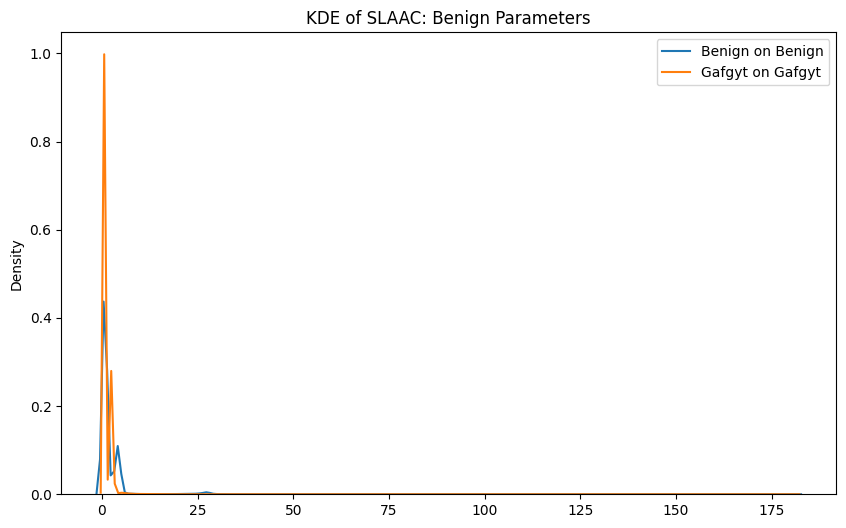

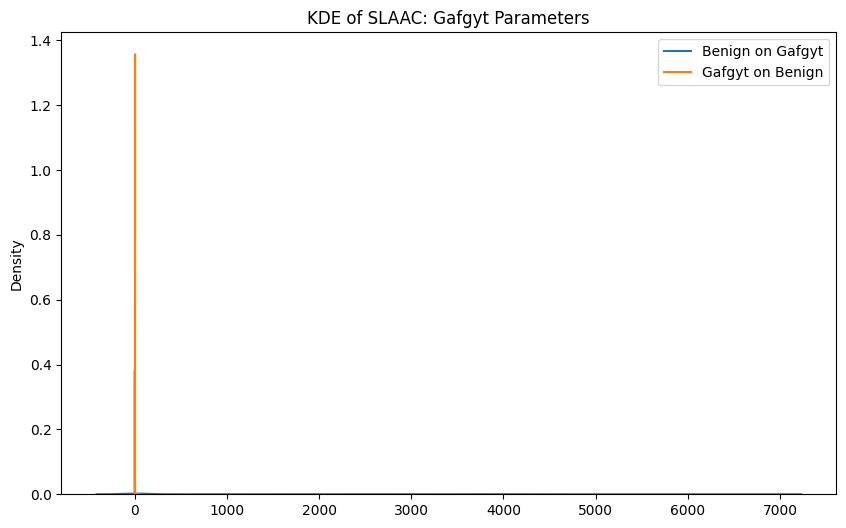

In [27]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Given omega_k_values as a dict and X_train, y_train
omega_k_values = {
    'HpHp_L5_magnitude':     0.292436,
    'HH_L5_magnitude':       0.285024,
    'MI_dir_L5_weight':      0.259694,
    'H_L5_weight':           0.259694,
    'HH_jit_L5_mean':        0.257857,
    'HH_L5_mean':            0.257612,
    'MI_dir_L5_mean':        0.228817,
    'H_L5_mean':             0.228714,
    'HpHp_L5_mean':          0.227574,
    'MI_dir_L5_variance':    0.121734,
    'H_L5_variance':         0.121375,
    'HH_L5_weight':          0.077117,
    'HH_jit_L5_weight':      0.076681,
    'HH_L5_std':             0.053011,
    'HH_L5_radius':          0.038005,
    'HpHp_L5_weight':        0.016331,
    'HH_L5_pcc':             0.014633,
    'HpHp_L5_std':           0.009637,
    'HH_L5_covariance':      0.001687,
    'HpHp_L5_radius':        0.000487,
    'HH_jit_L5_variance':    0.000331,
    'HpHp_L5_covariance':    0.000231,
    'HpHp_L5_pcc':           0.000000
}

# Normalize omega_k_values
sum_omega = sum(omega_k_values.values())
omega_k_values = {k: v / sum_omega for k, v in omega_k_values.items()}

# Convert the normalized dict to a numpy array
all_features = X_train.columns.tolist()
omega_k_array = np.array([omega_k_values[feat] for feat in all_features])

def vectorized_compute_SLARC(X_values, mu_k_values, sigma_k_values, omega_k_values, x_k_min_values, x_k_max_values):
    # x0 = mu_k
    x0_values = mu_k_values

    # delta = |x1 - x0|
    delta = np.abs(X_values - x0_values)

    # sgn_term is set to 1 here, but if needed, replicate exact logic from before
    sgn_term = 1

    # Compute rho_k_mu
    denom_mu = mu_k_values - x_k_min_values
    denom_mu = np.where(denom_mu == 0, 1e-6, denom_mu)
    rho_k_mu = (x_k_max_values - mu_k_values) / denom_mu
    rho_k_mu = np.nan_to_num(rho_k_mu, nan=0, posinf=0, neginf=0)

    # Compute rho_k_x1
    denom_x1 = X_values - x_k_min_values
    denom_x1 = np.where(denom_x1 == 0, 1e-6, denom_x1)
    rho_k_x1 = (x_k_max_values - X_values) / denom_x1
    rho_k_x1 = np.nan_to_num(rho_k_x1, nan=0, posinf=0, neginf=0)

    # Compute epsilon_k
    condition = (rho_k_mu - 1) * (rho_k_x1 - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        reciprocal_rho = np.where(rho_k_mu != 0, 1.0 / rho_k_mu, 0)
    epsilon_candidates = np.maximum(rho_k_mu, reciprocal_rho)
    epsilon_k = np.where(condition >= 0, 1, epsilon_candidates)
    epsilon_k = np.nan_to_num(epsilon_k, nan=0, posinf=0, neginf=0)

    # Compute SLARC_k
    slarc_k = (omega_k_values / sigma_k_values) * epsilon_k * delta * sgn_term
    slarc_k = np.nan_to_num(slarc_k, nan=0, posinf=0, neginf=0)

    # sum over features and multiply by sqrt(pi/2)
    total_SLARC = slarc_k.sum(axis=1) * math.sqrt(math.pi / 2)
    return total_SLARC

def compute_slaac_values(X, y, class_label, omega_k_array, X_eval=None):
    global mu_k_g, mu_k_b, sigma_k_g, x_k_min_g, x_k_max_g, sigma_k_b, x_k_min_b, x_k_max_b
    # Compute class-specific parameters from class_label
    X_class = X[y == class_label]

    if class_label == 2:
        mu_k = mu_k_g
        sigma_k = sigma_k_g
        x_k_min = x_k_min_g
        x_k_max = x_k_max_g
    elif class_label == 0:
        mu_k = mu_k_b
        sigma_k = sigma_k_b
        x_k_min = x_k_min_b
        x_k_max = x_k_max_b
    else:
        mu_k = X_class.mean()
        sigma_k = X_class.std()
        x_k_min = X_class.quantile(0.01)
        x_k_max = X_class.quantile(0.99)


    mu_k_values = mu_k.values
    sigma_k_values = sigma_k.values
    x_k_min_values = x_k_min.values
    x_k_max_values = x_k_max.values

    # If no X_eval provided, evaluate on the same class
    if X_eval is None:
        X_eval = X_class
    X_values = X_eval.values

    slaac_values = vectorized_compute_SLARC(
        X_values,
        mu_k_values,
        sigma_k_values,
        omega_k_array,
        x_k_min_values,
        x_k_max_values
    )

    return slaac_values, slaac_values.mean(), slaac_values.std()

# Example usage:
# Assume class 0 = Benign, class 2 = Gafgyt
# Compute SLAAC for benign class parameters evaluated on benign instances
slaac_values_benign, mu_slaac_benign, std_slaac_benign = compute_slaac_values(X_train, y_train, 0, omega_k_array)
# Compute SLAAC for gafgyt class parameters evaluated on gafgyt instances
slaac_values_gafgyt, mu_slaac_gafgyt, std_slaac_gafgyt = compute_slaac_values(X_train, y_train, 2, omega_k_array)

# Reverse classes: compute SLAAC for benign parameters on gafgyt instances
X_gafgyt = X_train[y_train == 2]
slaac_values_benign_on_gafgyt, mu_benign_on_gafgyt, std_benign_on_gafgyt = compute_slaac_values(X_train, y_train, 0, omega_k_array, X_eval=X_gafgyt)

# Compute SLAAC for gafgyt parameters on benign instances
X_benign = X_train[y_train == 0]
slaac_values_gafgyt_on_benign, mu_gafgyt_on_benign, std_gafgyt_on_benign = compute_slaac_values(X_train, y_train, 2, omega_k_array, X_eval=X_benign)

slaac_results = {
    "mu_slaac_benign": mu_slaac_benign,
    "std_slaac_benign": std_slaac_benign,
    "mu_slaac_gafgyt": mu_slaac_gafgyt,
    "std_slaac_gafgyt": std_slaac_gafgyt,
    "mu_slaac_benign_on_gafgyt": mu_benign_on_gafgyt,
    "std_slaac_benign_on_gafgyt": std_benign_on_gafgyt,
    "mu_slaac_gafgyt_on_benign": mu_gafgyt_on_benign,
    "std_slaac_gafgyt_on_benign": std_gafgyt_on_benign
}

print("Mu SLAAC (Benign on Benign):", mu_slaac_benign)
print("Std SLAAC (Benign on Benign):", std_slaac_benign)
print("Mu SLAAC (Gafgyt on Gafgyt):", mu_slaac_gafgyt)
print("Std SLAAC (Gafgyt on Gafgyt):", std_slaac_gafgyt)
print("\nMu SLAAC (Benign on Gafgyt):", mu_benign_on_gafgyt)
print("Std SLAAC (Benign on Gafgyt):", std_benign_on_gafgyt)
print("Mu SLAAC (Gafgyt on Benign):", mu_gafgyt_on_benign)
print("Std SLAAC (Gafgyt on Benign):", std_gafgyt_on_benign)

# Plot KDE for visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(slaac_values_benign, label='Benign on Benign')
sns.kdeplot(slaac_values_gafgyt, label='Gafgyt on Gafgyt')
plt.title("KDE of SLAAC: Benign Parameters")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(slaac_values_benign_on_gafgyt, label='Benign on Gafgyt')
sns.kdeplot(slaac_values_gafgyt_on_benign, label='Gafgyt on Benign')
plt.title("KDE of SLAAC: Gafgyt Parameters")
plt.legend()
plt.show()

In [94]:
# In y sets, if label is > 0, replace it with 1 (binary classification)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

# Train and evaluate accuracy and F1 score of a XGBoost model
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.99977
F1 score: 0.99978



In [45]:
# In y sets, if label is > 0, replace it with 1 (binary classification)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

# Train and evaluate accuracy and F1 score of a XGBoost model
model2 = XGBClassifier(random_state=42)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.99996
F1 score: 0.99996



In [ ]:
# Import logistic regression
from sklearn.linear_model import RidgeClassifier

# In y sets, if label is > 0, replace it with 1 (binary classification)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

model3 = RidgeClassifier()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.98607
F1 score: 0.98686



In [ ]:
from sklearn.svm import SVC

# Ensure binary classification (already done)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

# Train SVC on the subset
model4 = SVC(kernel='linear', class_weight='balanced', random_state=42)
lim = 1000
model4.fit(X_train[:lim], y_train[:lim])

# Evaluate SVC
y_pred = model4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Output results
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}")

Accuracy: 0.99738
F1 score: 0.99741


In [ ]:
# Import logistic regression
from sklearn.linear_model import LogisticRegression

# In y sets, if label is > 0, replace it with 1 (binary classification)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

model5 = LogisticRegression()
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.93554
F1 score: 0.91872



In [ ]:
# Import PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# In y sets, if label is > 0, replace it with 1 (binary classification)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

model6 = PassiveAggressiveClassifier()
model6.fit(X_train, y_train)
y_pred = model6.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.99799
F1 score: 0.99800



In [37]:
# Import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# In y sets, if label is > 0, replace it with 1 (binary classification)
y_train = y_train.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})
y_test = y_test.replace({1: 1, 2: 1, 3: 1, 4: 1, 5: 1})

model7 = LinearDiscriminantAnalysis()
model7.fit(X_train, y_train)
y_pred = model7.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.5f}")
print(f"F1 score: {f1:.5f}\n")

Accuracy: 0.97863
F1 score: 0.98038



In [56]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import time

for mod in [model4, model5, model6, model7]:
    print(f"Model: {mod.__class__.__name__}, natural accuracy over 100 samples: {np.sum(mod.predict(X_attack100) == 1) / 100}")

def apply_attack(model_wrapper, n_trials_nei=250, X_attack=X_attack):
    # Define the constraints for the attack: clip values between 1st and 99th percentiles
    clip_min = X_train.quantile(0.01)
    clip_max = X_train.quantile(0.99)
    constraints = {
        "equality": [],
        "inequality": [],
        "clip_min": list(clip_min),
        "clip_max": list(clip_max),
        "categorical": [None] * X_test.shape[1]
    }

    # Define the neighborhood function
    neighborhood = Radar(constraints, max_iter_generation=n_trials_nei, enable_warning_message=False)

    # Define the likelihood function
    def compute_likelihood(slaac_x_adv_g, slaac_x_adv_b, mu_gafgyt, std_gafgyt, mu_benign, std_benign):
        #pdf_gafgyt = norm.pdf(slaac_x_adv_g, loc=mu_gafgyt, scale=std_gafgyt)
        #pdf_benign = norm.pdf(slaac_x_adv_b, loc=mu_benign, scale=std_benign)
        #likelihood = pdf_gafgyt / (pdf_gafgyt + pdf_benign)
        cdf_gafgyt = norm.cdf(slaac_x_adv_gafgyt, loc=mu_gafgyt, scale=std_gafgyt)
        likelihood = 1 - cdf_gafgyt
        return likelihood

    # Metrics storage
    results = {"HillClimbing": [], "SimulatedAnnealing": [], "TabuSearch": []}
    attack_stats = {
        "HillClimbing": {"success_count": 0, "likelihoods": []},
        "SimulatedAnnealing": {"success_count": 0, "likelihoods": []},
        "TabuSearch": {"success_count": 0, "likelihoods": []},
    }

    # Compute mu_k, sigma_k, x_k_min, and x_k_max for benign label
    mu_benign = X_train[y_train == 0].mean()
    sigma_benign = X_train[y_train == 0].std().replace(0, 1e-6)  # Avoid division by zero
    x_k_min_benign = X_train[y_train == 0].quantile(0.01)
    x_k_max_benign = X_train[y_train == 0].quantile(0.99)

    # Attack loop
    for k, x in enumerate(X_attack):
        print(f"\nRunning attack for sample {k + 1}...")
        for attack in [HillClimbing(estimator=model_wrapper, verbose=0),
                    SimulatedAnnealing(estimator=model_wrapper, verbose=0),
                    TabuSearch(estimator=model_wrapper, verbose=0)]:
            attack_name = attack.__class__.__name__
            t0 = time.time()
            if model_wrapper.predict([x])[0] == 1:
                try:
                    result = attack.run(
                        input=x,
                        cost_function=SLARC_cost_function,
                        targeted=False,
                        neighborhood=neighborhood,
                        max_iter=200,
                        patience=100,
                    )
                except Exception as e:
                    #print(f"Error in {attack_name}: {e}")
                    continue
            else: # misclassification naturally occured, no need to attack
                result = [x]

            x_adv = result[0]
            y_pred = model_wrapper.predict([x_adv])[0]

            # Compute SLAAC values
            slaac_x_adv_gafgyt = SLARC_cost_function(x0=mu_k_g, x1=x_adv, mu_k=mu_k_g,
                                                     sigma_k=sigma_k_g, x_k_min=x_k_min_g, x_k_max=x_k_max_g)  # Towards gafgyt
            slaac_x_adv_benign = SLARC_cost_function(x0=mu_k_b, x1=x_adv, mu_k=mu_k_b,
                                                     sigma_k=sigma_k_b, x_k_min=x_k_min_b, x_k_max=x_k_max_b)  # Towards benign

            # Compute likelihood
            likelihood = compute_likelihood(
                slaac_x_adv_gafgyt,
                slaac_x_adv_benign,
                mu_slaac_gafgyt, std_slaac_gafgyt,
                mu_slaac_benign, std_slaac_benign
            )


            # Store results
            results[attack_name].append({
                "sample": k + 1,
                "success": int(y_pred == 0),
                "relative_cost": SLARC_cost_function(x0=x, x1=x_adv),
                "absolute_cost": slaac_x_adv_gafgyt,
                "likelihood": likelihood
            })

            if y_pred == 0:  # Attack succeeded
                attack_stats[attack_name]["success_count"] += 1
                attack_stats[attack_name]["likelihoods"].append(likelihood)

            print(f"{attack_name:<20} | Likelihood: {likelihood:<8.4f} | SLAAC Gafgyt: {slaac_x_adv_gafgyt:<8.4f} | SLAAC Benign: {slaac_x_adv_benign:<8.4f} | Success: {str(y_pred == 0):<6} | Time: {time.time() - t0:<6.2f}s")


    # Output metrics for each attack
    for attack_name, stats in attack_stats.items():
        success_count = stats["success_count"]
        likelihoods = stats["likelihoods"]
        avg_likelihood = np.mean(likelihoods) if likelihoods else 0
        max_likelihood = np.max(likelihoods) if likelihoods else 0


        print(f"\n{attack_name}:")
        print(f"  Success Rate: {success_count / len(X_attack) * 100:.2f}%")
        print(f"  Average Likelihood: {avg_likelihood:.4f}")
        print(f"  Maximum Likelihood: {max_likelihood:.4f}")

Model: SVC, natural accuracy over 100 samples: 1.0
Model: LogisticRegression, natural accuracy over 100 samples: 0.94
Model: PassiveAggressiveClassifier, natural accuracy over 100 samples: 1.0
Model: LinearDiscriminantAnalysis, natural accuracy over 100 samples: 0.97


In [ ]:
apply_attack(model2, n_trials_nei=10000) # XGBClassifier


Running attack for sample 1...

Running attack for sample 2...

Running attack for sample 3...

Running attack for sample 4...
HillClimbing         | Likelihood: 0.1424   | SLAAC Gafgyt: 4.6590   | SLAAC Benign: 8666.0145 | Success: True   | Time: 8.68  s
TabuSearch           | Likelihood: 0.1361   | SLAAC Gafgyt: 4.7485   | SLAAC Benign: 8874.6243 | Success: True   | Time: 1.97  s

Running attack for sample 5...
HillClimbing         | Likelihood: 0.4874   | SLAAC Gafgyt: 1.4214   | SLAAC Benign: 12.9010  | Success: True   | Time: 1.81  s
SimulatedAnnealing   | Likelihood: 0.5011   | SLAAC Gafgyt: 1.3140   | SLAAC Benign: 60.5295  | Success: True   | Time: 0.67  s
TabuSearch           | Likelihood: 0.5078   | SLAAC Gafgyt: 1.2619   | SLAAC Benign: 40.3452  | Success: True   | Time: 0.80  s

Running attack for sample 6...
HillClimbing         | Likelihood: 0.5212   | SLAAC Gafgyt: 1.1568   | SLAAC Benign: 27.9023  | Success: True   | Time: 1.80  s
SimulatedAnnealing   | Likelihood: 0.4

In [91]:
apply_attack(model, n_trials_nei=250) # KNeighborsClassifier


Running attack for sample 1...

Running attack for sample 2...

Running attack for sample 3...

Running attack for sample 4...

Running attack for sample 5...
HillClimbing         | Likelihood: 0.5186   | SLAAC Gafgyt: 1.1771   | SLAAC Benign: 12.9272  | Success: True   | Time: 6.79  s
SimulatedAnnealing   | Likelihood: 0.5065   | SLAAC Gafgyt: 1.2724   | SLAAC Benign: 17.4468  | Success: True   | Time: 6.33  s
TabuSearch           | Likelihood: 0.4967   | SLAAC Gafgyt: 1.3490   | SLAAC Benign: 20.9898  | Success: True   | Time: 9.64  s

Running attack for sample 6...
HillClimbing         | Likelihood: 0.5075   | SLAAC Gafgyt: 1.2642   | SLAAC Benign: 12.9120  | Success: True   | Time: 7.32  s
SimulatedAnnealing   | Likelihood: 0.5228   | SLAAC Gafgyt: 1.1442   | SLAAC Benign: 12.7471  | Success: True   | Time: 6.44  s
TabuSearch           | Likelihood: 0.5142   | SLAAC Gafgyt: 1.2118   | SLAAC Benign: 43.3821  | Success: True   | Time: 9.50  s

Running attack for sample 7...
HillClim

In [ ]:
apply_attack(model3, n_trials_nei=10000) # RidgeClassifier


Running attack for sample 1...
HillClimbing         | Likelihood: 0.0119   | SLAAC Gafgyt: 8.3768   | SLAAC Benign: 7963.1022 | Success: True   | Time: 1.95  s
TabuSearch           | Likelihood: 0.0078   | SLAAC Gafgyt: 8.8644   | SLAAC Benign: 8384.9294 | Success: True   | Time: 0.92  s

Running attack for sample 2...
HillClimbing         | Likelihood: 0.0189   | SLAAC Gafgyt: 7.7994   | SLAAC Benign: 8777.1281 | Success: True   | Time: 2.03  s
SimulatedAnnealing   | Likelihood: 0.0001   | SLAAC Gafgyt: 12.7943  | SLAAC Benign: 8855.6429 | Success: True   | Time: 0.74  s

Running attack for sample 3...
HillClimbing         | Likelihood: 0.0000   | SLAAC Gafgyt: 14.8644  | SLAAC Benign: 5870.6119 | Success: True   | Time: 1.26  s
SimulatedAnnealing   | Likelihood: 0.0000   | SLAAC Gafgyt: 15.6157  | SLAAC Benign: 7614.1955 | Success: True   | Time: 1.59  s

Running attack for sample 4...
HillClimbing         | Likelihood: 0.0060   | SLAAC Gafgyt: 9.1575   | SLAAC Benign: 9044.7880 | S

In [55]:
apply_attack(model4, n_trials_nei=1000, X_attack=X_attack100) # SVC


Running attack for sample 1...

Running attack for sample 2...

Running attack for sample 3...

Running attack for sample 4...

Running attack for sample 5...

Running attack for sample 6...

Running attack for sample 7...

Running attack for sample 8...

Running attack for sample 9...

Running attack for sample 10...

Running attack for sample 11...

Running attack for sample 12...

Running attack for sample 13...

Running attack for sample 14...

Running attack for sample 15...

Running attack for sample 16...

Running attack for sample 17...

Running attack for sample 18...

Running attack for sample 19...

Running attack for sample 20...

Running attack for sample 21...

Running attack for sample 22...

Running attack for sample 23...

Running attack for sample 24...

Running attack for sample 25...

Running attack for sample 26...

Running attack for sample 27...

Running attack for sample 28...

Running attack for sample 29...

Running attack for sample 30...

Running attack for

In [51]:
apply_attack(model5, n_trials_nei=10000) # LogisticRegression


Running attack for sample 1...

Running attack for sample 2...

Running attack for sample 3...

Running attack for sample 4...
HillClimbing         | Likelihood: 0.0814   | SLAAC Gafgyt: 5.6766   | SLAAC Benign: 8733.0522 | Success: True   | Time: 0.01  s
SimulatedAnnealing   | Likelihood: 0.0814   | SLAAC Gafgyt: 5.6766   | SLAAC Benign: 8733.0522 | Success: True   | Time: 0.01  s
TabuSearch           | Likelihood: 0.0814   | SLAAC Gafgyt: 5.6766   | SLAAC Benign: 8733.0522 | Success: True   | Time: 0.01  s

Running attack for sample 5...

Running attack for sample 6...

Running attack for sample 7...

Running attack for sample 8...

Running attack for sample 9...

Running attack for sample 10...

Running attack for sample 11...

Running attack for sample 12...

Running attack for sample 13...

Running attack for sample 14...

Running attack for sample 15...

Running attack for sample 16...

Running attack for sample 17...

Running attack for sample 18...
HillClimbing         | Likel

In [57]:
apply_attack(model6, n_trials_nei=1000, X_attack=X_attack100) # PassiveAggressiveClassifier


Running attack for sample 1...

Running attack for sample 2...

Running attack for sample 3...

Running attack for sample 4...

Running attack for sample 5...

Running attack for sample 6...

Running attack for sample 7...

Running attack for sample 8...

Running attack for sample 9...

Running attack for sample 10...

Running attack for sample 11...

Running attack for sample 12...

Running attack for sample 13...

Running attack for sample 14...

Running attack for sample 15...

Running attack for sample 16...

Running attack for sample 17...

Running attack for sample 18...

Running attack for sample 19...

Running attack for sample 20...

Running attack for sample 21...

Running attack for sample 22...

Running attack for sample 23...

Running attack for sample 24...

Running attack for sample 25...

Running attack for sample 26...

Running attack for sample 27...

Running attack for sample 28...

Running attack for sample 29...

Running attack for sample 30...

Running attack for

In [53]:
apply_attack(model7, n_trials_nei=10000) # LinearDiscriminantAnalysis


Running attack for sample 1...
HillClimbing         | Likelihood: 0.0051   | SLAAC Gafgyt: 9.3272   | SLAAC Benign: 8747.6944 | Success: True   | Time: 2.03  s
SimulatedAnnealing   | Likelihood: 0.0189   | SLAAC Gafgyt: 7.8016   | SLAAC Benign: 8437.8781 | Success: True   | Time: 0.81  s
TabuSearch           | Likelihood: 0.0096   | SLAAC Gafgyt: 8.6299   | SLAAC Benign: 8735.8007 | Success: True   | Time: 0.67  s

Running attack for sample 2...
HillClimbing         | Likelihood: 0.0210   | SLAAC Gafgyt: 7.6682   | SLAAC Benign: 8845.9849 | Success: True   | Time: 1.38  s
SimulatedAnnealing   | Likelihood: 0.0126   | SLAAC Gafgyt: 8.3040   | SLAAC Benign: 8098.2392 | Success: True   | Time: 0.33  s
TabuSearch           | Likelihood: 0.0218   | SLAAC Gafgyt: 7.6153   | SLAAC Benign: 8844.5995 | Success: True   | Time: 0.67  s

Running attack for sample 3...
HillClimbing         | Likelihood: 0.0001   | SLAAC Gafgyt: 12.8367  | SLAAC Benign: 1511.4727 | Success: True   | Time: 1.02  s
S

In [79]:
def HAR(avg, suc):
    return -np.log2(avg * suc)


lda_average_likelihood = (0.40*0.0157 + 0.40*0.0148 + 0.40*0.0175)/(0.40 + 0.40 + 0.40)
lda_success_rate = (0.40 + 0.40 + 0.40)/3
lda_max_likelihood = 0.0461

print(f"LDA on N-BaIoT:\n"
      f"- F1-score: 0.98038\n"
      f"- Average Likelihood: {lda_average_likelihood:.4f}\n"
      f"- Success Rate: {lda_success_rate:.2f}\n"
      f"- Maximum Likelihood: {lda_max_likelihood:.4f}\n"
      f"- {HAR(lda_average_likelihood, lda_success_rate):.1f}-bits robust\n")


logistic_average_likelihood = (0.35*0.0098 + 0.25*0.0282 + 0.25*0.0154)/(0.35 + 0.25 + 0.25)
logistic_success_rate = (0.35 + 0.25 + 0.25)/3
logistic_max_likelihood = 0.0282

print(f"Ridge classifier on N-BaIoT:\n"
      f"- F1-score: 0.98686\n"
      f"- Average Likelihood: {logistic_average_likelihood:.4f}\n"
      f"- Maximum Likelihood: {logistic_max_likelihood:.4f}\n"
      f"- Success Rate: {logistic_success_rate:.2f}\n"
      f"- {HAR(logistic_average_likelihood, logistic_success_rate):.1f}-bits robust\n")


svc_average_likelihood = (0.01*0.4265 + 0.01*0.4540 + 0.01*0.3709)/(0.01 + 0.01 + 0.01)
svc_success_rate = (0.01 + 0.01 + 0.01)/3
svc_max_likelihood = 0.4540

print(f"SVC on N-BaIoT:\n"
      f"- F1-score: 0.99741\n"
      f"- Average Likelihood: {svc_average_likelihood:.4f}\n"
      f"- Success Rate: {svc_success_rate:.2f}\n"
      f"- Maximum Likelihood: {svc_max_likelihood:.4f}\n"
      f"- {HAR(svc_average_likelihood, svc_success_rate):.1f}-bits robust\n")


passive_aggressive_average_likelihood = (0.01*0.2493)/(0.01)
passive_aggressive_success_rate = (0.01)/3
passive_aggressive_max_likelihood = 0.2493

print(f"Passive Aggressive on N-BaIoT:\n"
      f"- F1-score: 0.99800\n"
      f"- Average Likelihood: {passive_aggressive_average_likelihood:.4f}\n"
      f"- Success Rate: {passive_aggressive_success_rate:.2f}\n"
      f"- Maximum Likelihood: {passive_aggressive_max_likelihood:.4f}\n"
      f"- {HAR(passive_aggressive_average_likelihood, passive_aggressive_success_rate):.1f}-bits robust\n")


neighbors_average_likelihood = (0.65*0.4716 + 0.65*0.4806 + 0.65*0.4753)/(0.65 + 0.65 + 0.65)
neighbors_success_rate = (0.65 + 0.65 + 0.65)/3
neighbors_max_likelihood = 0.5242

print(f"Neighborhood attacks on N-BaIoT:\n"
      f"- F1-score: 0.99978\n"
      f"- Average Likelihood: {neighbors_average_likelihood:.4f}\n"
      f"- Success Rate: {neighbors_success_rate:.2f}\n"
      f"- Maximum Likelihood: {neighbors_max_likelihood:.4f}\n"
      f"- {HAR(neighbors_average_likelihood, neighbors_success_rate):.1f}-bits robust\n")


xgboost_average_likelihood = (0.75*0.4337 + 0.70*0.4591 + 0.80*0.4194)/(0.75 + 0.70 + 0.80)
xgboost_success_rate = (0.75 + 0.70 + 0.80)/3
xgboost_max_likelihood = 0.5333

print(f"XGBoost on N-BaIoT:\n"
      f"- F1-score: 0.99996\n"
      f"- Average Likelihood: {xgboost_average_likelihood:.4f}\n"
      f"- Success Rate: {xgboost_success_rate:.2f}\n"
      f"- Maximum Likelihood: {xgboost_max_likelihood:.4f}\n"
      f"- {HAR(xgboost_average_likelihood, xgboost_success_rate):.1f}-bits robust\n")

LDA on N-BaIoT:
- F1-score: 0.98038
- Average Likelihood: 0.0160
- Success Rate: 0.40
- Maximum Likelihood: 0.0461
- 7.3-bits robust

Ridge classifier on N-BaIoT:
- F1-score: 0.98686
- Average Likelihood: 0.0169
- Maximum Likelihood: 0.0282
- Success Rate: 0.28
- 7.7-bits robust

SVC on N-BaIoT:
- F1-score: 0.99741
- Average Likelihood: 0.4171
- Success Rate: 0.01
- Maximum Likelihood: 0.4540
- 7.9-bits robust

Passive Aggressive on N-BaIoT:
- F1-score: 0.99800
- Average Likelihood: 0.2493
- Success Rate: 0.00
- Maximum Likelihood: 0.2493
- 10.2-bits robust

Neighborhood attacks on N-BaIoT:
- F1-score: 0.99978
- Average Likelihood: 0.4758
- Success Rate: 0.65
- Maximum Likelihood: 0.5242
- 1.7-bits robust

XGBoost on N-BaIoT:
- F1-score: 0.99996
- Average Likelihood: 0.4365
- Success Rate: 0.75
- Maximum Likelihood: 0.5333
- 1.6-bits robust



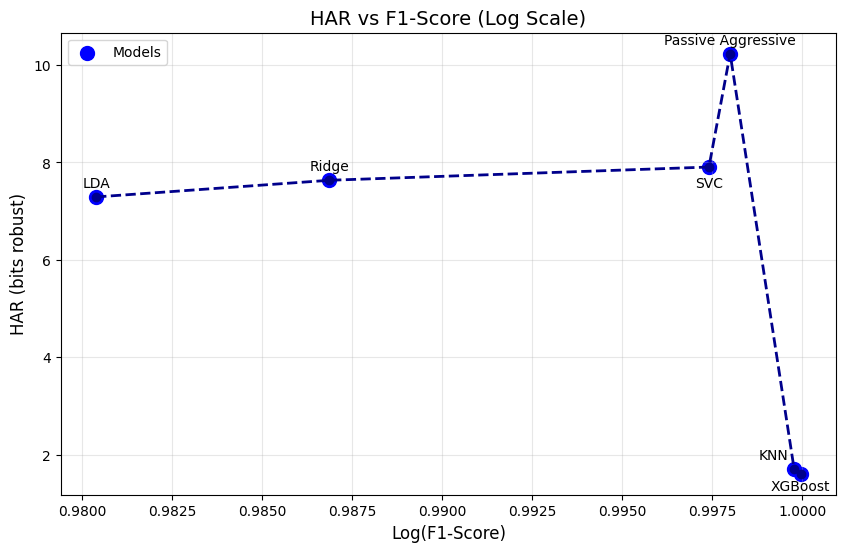

<Figure size 640x480 with 0 Axes>

In [112]:
def HAR(avg, suc):
    return -np.log2(avg * suc)

# Data for plotting
data = [
    {"name": "LDA", "f1_score": 0.98038, "avg_likelihood": 0.01596666667, "success_rate": 0.40},
    {"name": "Ridge", "f1_score": 0.98686, "avg_likelihood": 0.01778, "success_rate": 0.2833},
    {"name": "SVC", "f1_score": 0.99741, "avg_likelihood": 0.41713, "success_rate": 0.01},
    {"name": "Passive Aggressive", "f1_score": 0.99800, "avg_likelihood": 0.2493, "success_rate": 0.003333},
    {"name": "KNN", "f1_score": 0.99978, "avg_likelihood": 0.47583, "success_rate": 0.65},
    {"name": "XGBoost", "f1_score": 0.99996, "avg_likelihood": 0.43819, "success_rate": 0.75},
]

# Compute HAR and prepare data for plotting
f1_scores = [entry["f1_score"] for entry in data]
har_values = [HAR(entry["avg_likelihood"], entry["success_rate"]) for entry in data]
labels = [entry["name"] for entry in data]

x_vals = f1_scores
y_vals = har_values

# Plot HAR vs F1-Score (log scale for F1-Score)
plt.figure(figsize=(10, 6))
plt.scatter(f1_scores, har_values, color="blue", s=100, label="Models")

# Annotate points
for i, label in enumerate(labels):
    if i == 5:
        plt.annotate(label, (f1_scores[i], har_values[i]), textcoords="offset points", xytext=(0, -12), ha="center")
    elif i == 2:
        plt.annotate(label, (f1_scores[i], har_values[i]), textcoords="offset points", xytext=(0, -15), ha="center")
    elif i == 4:
        plt.annotate(label, (f1_scores[i], har_values[i]), textcoords="offset points", xytext=(-15, 7), ha="center")
    else:
        plt.annotate(label, (f1_scores[i], har_values[i]), textcoords="offset points", xytext=(0, 7), ha="center")


plt.plot(x_vals, y_vals, color="darkblue", linestyle="--", linewidth=2, marker="o")

plt.title("HAR vs F1-Score (Log Scale)", fontsize=14)
plt.xlabel("Log(F1-Score)", fontsize=12)
plt.ylabel("HAR (bits robust)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

plt.savefig("graphs/har_vs_f1_score.png")